W tym notatniku będę analizował dane pobrane ze strony https://pl.wikipedia.org/wiki/Demografia_Polski

# Potrzebne importy

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup 
import matplotlib.pyplot as plt
from scipy import stats
import math
from scipy import optimize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Zadanie 2c

Pobranie danych ze strony:

In [2]:
URL = "https://pl.wikipedia.org/wiki/Demografia_Polski"
resp = requests.get(URL) 
if resp.status_code == 200:    # czy stronę udało się otworzyć?
    soup = BeautifulSoup(resp.content,'html.parser')  # utowrzenie drzewa wyszukiwań
    tab = soup.find_all('table',{'class':"wikitable"})   # ekstrakcja tabel z drzewa wyszukiwań

for tag in soup.find_all(class_="reference"): # usuwanie wikipediowych referencji
    tag.decompose()

W ramce o nazwie **demografia** będę przechowywał dane dotyczące demografii Polski w latach 1946 - 2021. Aby móc przetwarzać dane jako liczby formatuję dane za pomocą metody str.replace

In [3]:
demografia = pd.read_html(str(tab[6]))[0]
demografia['Rok'] = demografia['Rok'].fillna(0).astype(int)
demografia.drop(demografia[demografia['Rok'] == 0].index, inplace=True)

demografia.set_index('Rok', inplace=True)

demografia['Przyrostnaturalny'] = demografia['Przyrostnaturalny'].str.replace(" ", "") # usuń spacje z liczb
demografia['Przyrostnaturalny'] = demografia['Przyrostnaturalny'].str.replace("−", "-") # zastąp jeden rodzaj myślnika minusem
demografia['Przyrostnaturalny'] = demografia['Przyrostnaturalny'].str.replace("–", "-") # zastąp drugi rodzaj myślnika minusem
demografia['Przyrostnaturalny'] = demografia['Przyrostnaturalny'].astype(int)

display(demografia)

,"Populacja(w tys.,stan na 31.12.)",Urodzeniażywe,Zgonyogółem,Przyrostnaturalny,Współczynnikurodzeń żywych(na 1000),Współczynnikzgonów(na 1000),Przyrostnaturalny(na 1000),Dzietność,Imigracja,Emigracja,SaldoMigracji
Rok,,,,,,,,,,,
1946,23 640,622 500,241 800,380700,262.0,102.0,160,NaN,NaN,NaN,NaN
1947,23 754,681 200,258 400,422800,287.0,109.0,178,NaN,NaN,NaN,NaN
1948,24 211,704 800,267 300,437500,294.0,112.0,182,NaN,NaN,NaN,NaN
1949,24 613,725 100,280 500,444600,297.0,115.0,182,NaN,NaN,NaN,NaN
1950,25 035,763 100,288 700,474400,307.0,116.0,191,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2017,38 434,402 000,402 852,-852,105.0,105.0,00,1450.0,13 324,11 888,1 434
2018,38 411,388 200,414 200,-25789,101.0,108.0,"−0,7",1435.0,15 461,11 849,3 612
2019,38 383,374 800,409 709,-34909,98.0,107.0,"−0,9",1419.0,16 900,10 700,6 200


Z tej ramki będę się zajmował danymi dotyczącymi przyrostu naturalnego (*Przyrost naturalny* w danym roku to różnica między liczbą urodzeń żywych a liczbą zgonów):

In [4]:
display(demografia['Przyrostnaturalny'])

Rok
1946    380700
1947    422800
1948    437500
1949    444600
1950    474400
         ...  
2017      -852
2018    -25789
2019    -34909
2020   -122635
2021   -188000
Name: Przyrostnaturalny, Length: 76, dtype: int64

Na przyrost naturalny warto patrzeć z perspektywy dziesięcioleci. Zastosuję do celów wizualizacji średnią ruchomą.

In [5]:
demografia.insert(1, 'M_Przyrost', demografia['Przyrostnaturalny'].rolling(10).mean())

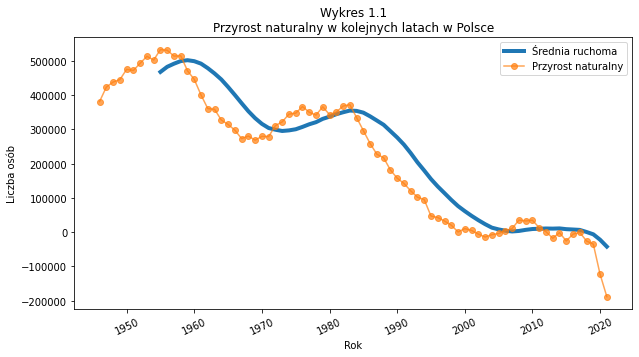

In [50]:
demografia['M_Przyrost'].plot(rot=25, figsize=(10,5), linewidth=4)
demografia['Przyrostnaturalny'].plot(rot=25, figsize=(10,5), marker='o', alpha=0.7)

plt.title("Wykres 1.1\nPrzyrost naturalny w kolejnych latach w Polsce")
plt.ylabel("Liczba osób")
plt.legend(['Średnia ruchoma', 'Przyrost naturalny'])

plt.show()

Niestety wraz z upływem czasu przyrost naturalny maleje, a w latach 2020 i 2021 wyniósł mniej niż 100 000. Z pewnością istnieją różne przyczyny tego zjawiska na przestrzeni lat. Uważam, że warto zbadać czy istnieje zależność między przyrostem naturalnym a średnią roczną stopą bezrobocia.

# Zadanie 3d

Odczytam teraz dane dotyczące bezrobocia w latach 2003 - 2019. Będę je przechowywał w ramce **bezrobocie**. W tym rozdziale sprawdzę, czy istnieje zależność między bezrobociem a przyrostem naturalnym

In [7]:
bezrobocie = pd.read_html(str(tab[7]))[0]
bezrobocie = bezrobocie.drop(index=0)
bezrobocie = bezrobocie.drop(index=1)
bezrobocie.set_index('Rok', inplace=True)
bezrobocie = bezrobocie.astype(float)
bezrobocie = bezrobocie / 10
display(bezrobocie)

,Styczeń,Luty,Marzec,Kwiecień,Maj,Czerwiec,Lipiec,Sierpień,Wrzesień,Październik,Listopad,Grudzień
Rok,,,,,,,,,,,,
2019,6.1,6.1,5.9,5.6,5.4,5.3,5.2,5.2,5.1,5.0,5.1,5.2
2018,6.8,6.8,6.6,6.3,6.1,5.8,5.8,5.8,5.7,5.7,5.7,5.8
2017,8.5,8.4,8.0,7.6,7.3,7.0,7.0,7.0,6.8,6.6,6.5,6.6
2016,10.2,10.2,9.9,9.4,9.1,8.7,8.5,8.4,8.3,8.2,8.2,8.2
2015,11.9,11.9,11.5,11.1,10.7,10.2,10.0,9.9,9.7,9.6,9.6,9.7
2014,13.9,13.9,13.5,13.0,12.5,12.0,11.8,11.7,11.5,11.3,11.4,11.4
2013,14.2,14.4,14.3,14.0,13.6,13.2,13.1,13.0,13.0,13.0,13.2,13.4
2012,13.2,13.4,13.3,12.9,12.6,12.3,12.3,12.4,12.4,12.5,12.9,13.4
2011,13.1,13.4,13.3,12.8,12.4,11.9,11.8,11.8,11.8,11.8,12.1,12.5


Liczby dla danych miesięcy i lat oznaczają stopę bezrobocia.
*Stopa bezrobocia* stanowi stosunek liczby bezrobotnych, którzy są zarejestrowani w powiatowych urzędach pracy do liczby ludności aktywnej zawodowo.

Dla każdego roku policzę średnią roczną stopę bezrobocia, i umieszcze te dane, razem z danymi dotyczącymi przyrostu naturalnego w ramce o nazwie **bezrobocie_przyrost**. Aby zwiększyć czytelność wykresów w dalszej części notatnika dane dotyczące przyrostu naturalnego będę podawał w tys.

In [8]:
bezrobocie['Średnia'] = bezrobocie.mean(axis=1)
bezrobocie_przyrost = bezrobocie['Średnia'].to_frame()

bezrobocie_przyrost.insert(1, 'Przyrostnaturalny', demografia['Przyrostnaturalny'])
bezrobocie_przyrost['Przyrostnaturalny'] = bezrobocie_przyrost['Przyrostnaturalny'] / 1000
bezrobocie_przyrost = bezrobocie_przyrost.round(2)

display(bezrobocie_przyrost)

,Średnia,Przyrostnaturalny
Rok,,
2019,5.43,-34.91
2018,6.07,-25.79
2017,7.27,-0.85
2016,8.94,-5.75
2015,10.48,-25.61
2014,12.32,-1.34
2013,13.53,-17.72
2012,12.80,1.46
2011,12.39,12.92


Używając gotowych metod z biblioteki sklearn wyznaczam modele i ocenieniam ich jakość za pomocą błędu średniokwadratowego.

In [12]:
def f(X_train, X_test, Y_train, Y_test):
  # =========  Model liniowy =========
  model_lin = LinearRegression()
  model_lin.fit(X_train.reshape(-1,1), 
                Y_train)
  print(f'Parametry modelu liniowego: {np.round(model_lin.coef_,5)}, {np.round(model_lin.intercept_,5)}')
  MSE_lin = mean_squared_error(Y_test, model_lin.predict(X_test.reshape(-1,1)))
  print(f'Błąd średniokwadratowy modelu liniowego: {MSE_lin:0.3}\n')

  # ===== Uogólniony model liniowy (ang. Generalized Linear Model) =====

  model_GLM = LinearRegression()
  gen_features = PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)
  model_GLM.fit(gen_features.fit_transform(X_train.reshape(-1,1)), 
                Y_train)
  print(f'Parametry modelu GLM: {np.round(model_GLM.coef_,4)}, {np.round(model_GLM.intercept_,5)}')
  MSE_GLM = mean_squared_error(Y_test, model_GLM.predict(gen_features.fit_transform(X_test.reshape(-1,1))))
  print(f'Błąd średniokwadratowy modelu GLM: {MSE_GLM:0.3}\n')

  # Predykcje wszystkich modeli dla całego zakreso osi X
  os_x = np.linspace(start=X.min(), stop=X.max(), num=300)
  y_lin_pred = model_lin.predict(os_x.reshape(-1,1))
  y_GLM_pred = model_GLM.predict(gen_features.fit_transform(os_x.reshape(-1,1)))

  # Wizualizacja
  plt.scatter(X_train, Y_train, label='dane treningowe', alpha=0.7)
  plt.scatter(X_test, Y_test, edgecolor='black', facecolor='none', label='dane testujące')
  plt.plot(os_x, y_lin_pred, label='model liniowy', color='tab:orange')
  plt.plot(os_x, y_GLM_pred, label=f'model GLM', color='tab:red')
  plt.xlabel("Średnia roczna stopa bezrobocia", fontsize=14)
  plt.ylabel("Przyrost naturalny w tys.", fontsize=14)
  plt.legend(fontsize=12, shadow=True, loc='lower right')
  plt.ylim([Y.min()-5, Y.max()+5])
  plt.show()

In [10]:
X = bezrobocie_przyrost['Średnia'].values
Y = bezrobocie_przyrost['Przyrostnaturalny'].values

Przeprowadzę 3 próby dla proporcji podziału pełnego zbioru danych na część "uczącą" (do wyznaczania parametrów modeli) i część "testującą" (do oceny jakości).

Próba 1, część ucząca = 30% danych

Parametry modelu liniowego: [0.0301], -5.68466
Błąd średniokwadratowy modelu liniowego: 5.52e+02

Parametry modelu GLM: [ 0.      1.8963 -0.068 ], -16.99107
Błąd średniokwadratowy modelu GLM: 5.05e+02



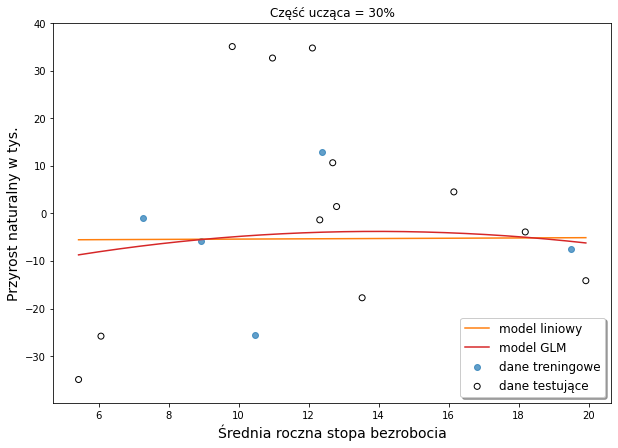

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.3)
plt.figure(figsize=(10,7))
plt.title("Część ucząca = 30%")
f(X_train, X_test, Y_train, Y_test)

Próba 2, część ucząca = 60% danych

Parametry modelu liniowego: [2.00048], -28.72949
Błąd średniokwadratowy modelu liniowego: 6.34e+02

Parametry modelu GLM: [ 0.     13.927  -0.5151], -90.03734
Błąd średniokwadratowy modelu GLM: 3.41e+02



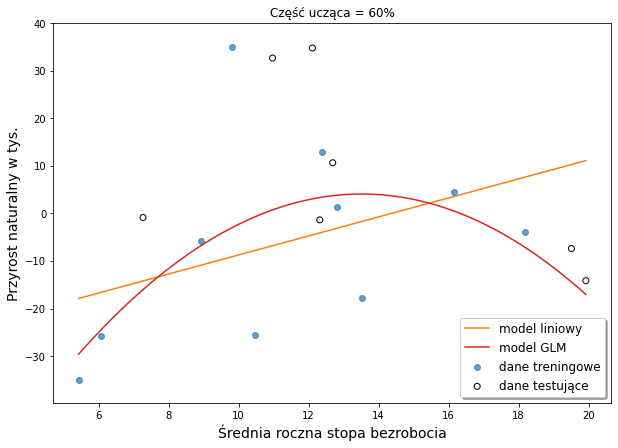

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.6)
plt.figure(figsize=(10,7))
plt.title("Część ucząca = 60%")
f(X_train, X_test, Y_train, Y_test)

Próba 3, część ucząca = 90% danych

Parametry modelu liniowego: [-0.06464], 2.09488
Błąd średniokwadratowy modelu liniowego: 3.78e+02

Parametry modelu GLM: [ 0.     15.6991 -0.5953], -91.95129
Błąd średniokwadratowy modelu GLM: 75.9



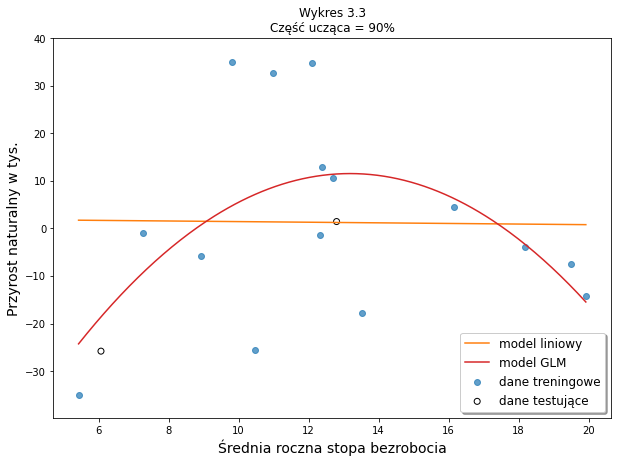

In [48]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.9)
plt.figure(figsize=(10,7))
plt.title("Wykres 3.3\nCzęść ucząca = 90%")
f(X_train, X_test, Y_train, Y_test)

Dzięki otrzymanym wykresom, oraz wartościom błędów średniokwadratowych możemy zauważyć, że jedynie modele otrzymane przy części "uczącej" posiadają przyzwoity błąd średniokwadratowy w porównaniu do reszty otrzymanych modeli. Na pierwszy rzut oka, nie ma żadnej koleracji między tymi dwoma zbiorami danych

# Zadanie 4b

Przyglądając wykresom z rozdziału "Zadanie 3d" można zauważyć, że wartości średniej stopy bezrobocia "na oko" do wartości 12. Aby móc z pełnym skupieniem wrócić do badania zależności opisanej w poprzednim rozdziale poświęce krótki kawałek pracy na zbadanie tej hipotezy.

Dokonam tego za pomocą testu Shapiro oraz testu D'Agostino

funkcja rozkładu normalnego:

In [23]:
def rozklad_norm(parametry, x):
    mu, sigma = parametry
    return np.exp(-(x-mu)**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))

Badając czy dane mają rozkład normalny przyjmujemy hipotezę H_0: "Dane mają rozkład normalny", oraz hipotezę H_1: "Dane nie mają rozkładu normalnego". Jeśli z testu otrzymamy p-wartość mniejszą niż 0.05 należy odrzucić hipotezę H_0.


Test Shapiro:

In [24]:
print(f'test Shapiro, p-wartość = {stats.shapiro(X)[1]}')

test Shapiro, p-wartość = 0.4739503860473633


Test D'Agostino

In [25]:
print(f'test D’Agostino i Pearsona, p-wartość = {stats.normaltest(X)[1]}\n')

test D’Agostino i Pearsona, p-wartość = 0.8076926334183886



/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


Dla obu testów p-wartość jest większa niż 0.05 zatem hipotezę o rozkładzie normalnym średniej stopy bezrobocia można uznać za prawdziwą

Jako, że testy nie odrzuciły hipotez, możemy przejść do wyznaczenia współczynników mu i sigma

In [26]:
mu, sigma= X.mean(), X.std()
print(f'mu = {mu}\nsigma = {sigma}')

mu = 12.270000000000001
sigma = 4.168081798903777


Oraz do ilustracji danych oraz modelu na wykresie

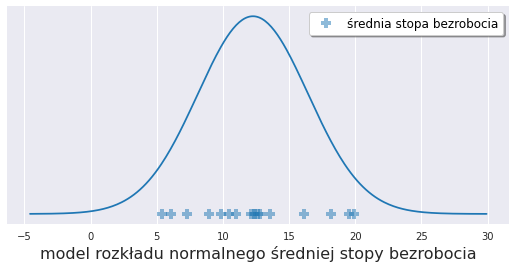

In [28]:
os_x = np.linspace(X.min()-10, X.max()+10, num=300)
os_y = rozklad_norm([mu, sigma], os_x)

with plt.style.context('seaborn'):  
    plt.figure(figsize=(9,4))
    plt.plot(X, np.zeros_like(X), 'P', 
             markersize=10, alpha=0.5, markerfacecolor='tab:blue', markeredgecolor='tab:blue', 
             label='średnia stopa bezrobocia')
    plt.plot(os_x, 25*os_y, color='tab:blue')
    plt.xlabel('model rozkładu normalnego średniej stopy bezrobocia', fontsize=16)
    plt.yticks([])

plt.legend(shadow=True, fontsize=12)
plt.show()

Hipoteza okazała się prawdziwa. Średnia stopa bezrobocia w Polsce ma rozkład normalny. Analiza tego odkrycia wychodzi jednak poza zakres tej pracy, zatem sformułowanie wniosków, jakie z tego faktu wynikają pozostawiam czytelnikowi.

# Zadanie 5d 

Za pomocą biblioteki **sklearn** w rozdziale "Zadanie 3d" nie udało się jednoznacznie wyznaczyć modelu określajądcego zależność badanych danych. Wszytskie informacje należy jednak zawsze konsultować z więcej niż jednym źródłem. Dlatego też podejmę próbę wyznaczenia modelu z pomocą biblioteki **scipy**.

Najpierw jednak należy zdefiniować błąd średniokwadratowy

**Błąd średniokwadratowy** <br>
Niech błąd przybliżenia dla pojedynczej $i$-tej pary pomiarów wynosi:
$$e_i=y_i-\overline{y_i}.$$

gdzie $$\overline{y_i}=ax_i + b$$

Miarą błędu niech będzie wyrażenie:

\begin{equation}
Q(v) = \frac{1}{N}\sqrt{\sum_{i=1}^Ne_i^2}\ 
\end{equation}

gdzie $$v = \left[ \begin{array}{c} a \\ b \end{array} \right].$$

In [29]:
def lin(v, x):
  a,b = v
  return a*x + b

In [30]:
def Q(v):
  s = 0
  for i in range(0, len(X)):
    s = s + (Y[i] - lin(v, X[i]))**2
  return s**(1/2)/len(X)

Funkcją celu będzie funckja Q(v). Będę szukał minimum tej funkcji za pomocą optimize.fmin()

Przed rozpoczęciem eksperymentów zdefiniuję funkcję pokaz_2D, która będzie służyć do wyświetlania historii poszukiwań rozwiązania optymalnego dla każdego z przeprowadzonych eksperymentów

In [34]:
def pokaz_2D(Fcelu, x_historia, zakres):
  x_pocz, x_opt = x_historia[0], x_historia[-1]
  os_x1 = np.linspace(zakres[0], zakres[1], num=100)
  os_x2 = np.linspace(zakres[2], zakres[3], num=100)
  siatka_X1, siatka_X2 = np.meshgrid(os_x1, os_x2)
  macierz_Z = Fcelu([siatka_X1, siatka_X2])

  fig, ax = plt.subplots(figsize=(10,10))
  cplot = ax.contourf(siatka_X1, siatka_X2, macierz_Z, 10, cmap='Spectral_r', alpha=1)
  clines = ax.contour(siatka_X1, siatka_X2, macierz_Z, 10, colors='black')
  for punkt in x_historia:
      ax.plot(punkt[0], punkt[1], 'o', 
              color='white', markeredgecolor='black', markersize=5, alpha=0.7)
  ax.plot(x_pocz[0], x_pocz[1], 'd', 
          color='gray', markeredgecolor='black', markersize=10, alpha=0.7)    
  ax.plot(x_opt[0], x_opt[1], 'h', 
          color='white', markeredgecolor='black', markersize=15)
  ax.set_aspect('equal')
  ax.set_xlabel(r'$a$', fontsize=16)
  ax.set_ylabel(r'$b$', fontsize=16)
  ax.clabel(clines)
  fig.colorbar(cplot)
  return fig, ax

Wykonam trzy eksperymenty, każdy dla różnych startowych punktów poszukiwań wybranych losowo

*   Eksperyment 1





In [33]:
v_pocz_1 = np.random.normal(loc=5, scale=5, size=2)

x_opt_1, x_historia_1 = optimize.fmin(Q, v_pocz_1,disp=False, retall=True)

Punkt startowy v = [0.09855412 6.01417119]
Współczynnik kierunkowy a = 0.5128503481729433
Współczynnik b = -6.596778050588064


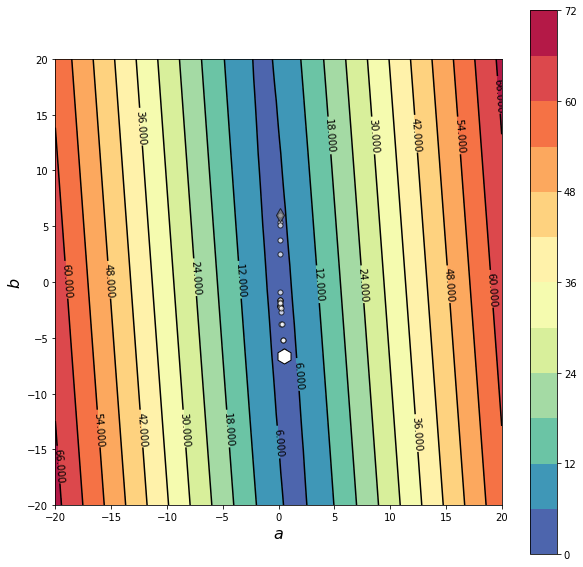

In [35]:
zakres=[-20, 20, -20, 20]
pokaz_2D(Q, x_historia_1, zakres)
print(f'Punkt startowy v = {v_pocz_1}')
print(f'Współczynnik kierunkowy a = {x_opt_1[0]}\nWspółczynnik b = {x_opt_1[1]}')
plt.show()

Wizualizacja znalezionego rozwiązania na tle chmury punktów

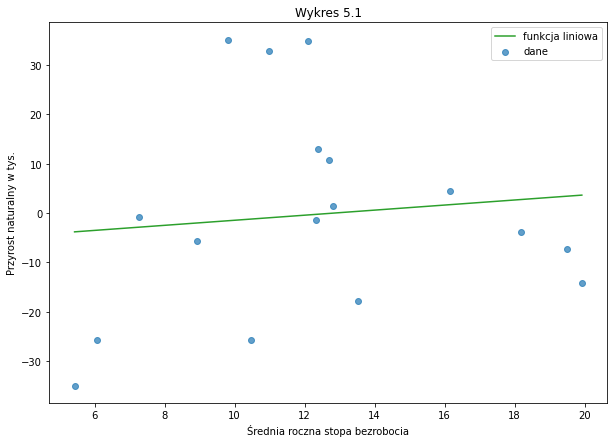

In [36]:
plt.figure(figsize=(10,7))
plt.scatter(X, Y, label='dane', alpha=0.7)
os_x = np.linspace(start=X.min(), stop=X.max(), num=300)
plt.plot(os_x, lin(x_opt_1, os_x), label='funkcja liniowa', color='tab:green')
plt.ylabel("Przyrost naturalny w tys.")
plt.title("Wykres 5.1")
plt.xlabel("Średnia roczna stopa bezrobocia")
plt.legend()
plt.show()



*   Eksperyment 2



In [37]:
v_pocz_2 = np.random.normal(loc=-30, scale=5, size=2)

x_opt_2, x_historia_2 = optimize.fmin(Q, v_pocz_2,disp=False, retall=True)

Punkt startowy v = [-25.8330903  -20.08882035]
Współczynnik kierunkowy a = 0.5128534497686793
Współczynnik b = -6.596822479465663


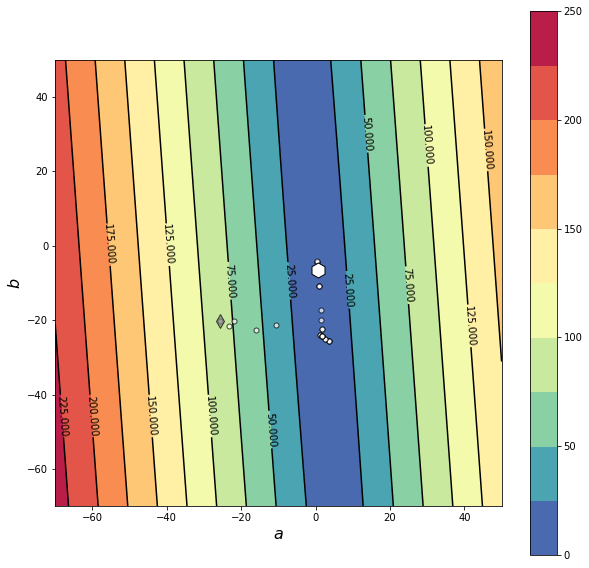

In [38]:
zakres=[-70, 50, -70, 50]
pokaz_2D(Q, x_historia_2, zakres)
print(f'Punkt startowy v = {v_pocz_2}')
print(f'Współczynnik kierunkowy a = {x_opt_2[0]}\nWspółczynnik b = {x_opt_2[1]}')
plt.show()

Wizualizacja znalezionego rozwiązania na tle chmury punktów

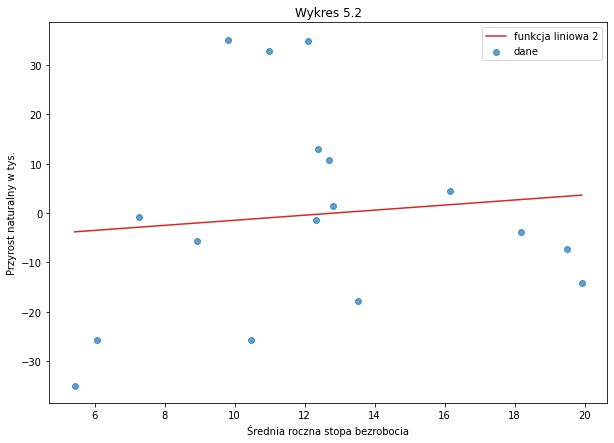

In [39]:
plt.figure(figsize=(10,7))
plt.scatter(X, Y, label='dane', alpha=0.7)
os_x = np.linspace(start=X.min(), stop=X.max(), num=300)
plt.plot(os_x, lin(x_opt_2, os_x), label='funkcja liniowa 2', color='tab:red')
plt.ylabel("Przyrost naturalny w tys.")
plt.xlabel("Średnia roczna stopa bezrobocia")
plt.title("Wykres 5.2")
plt.legend()
plt.show()



*   Eksperyment 3


In [45]:
v_pocz_3 = np.random.normal(loc=0, scale=75, size=2)

x_opt_3, x_historia_3 = optimize.fmin(Q, v_pocz_3,disp=False, retall=True)

Punkt startowy v = [64.52675827 90.52428318]
Współczynnik kierunkowy a = 0.5128492569050319
Współczynnik b = -6.596785229292262


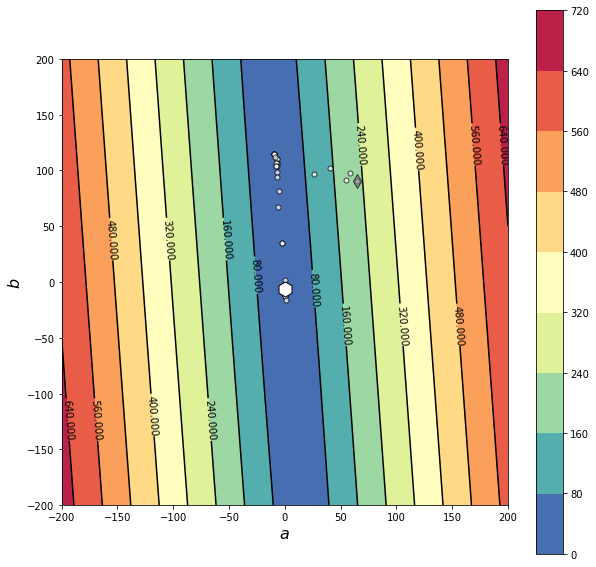

In [46]:
zakres=[-200, 200, -200, 200]
pokaz_2D(Q, x_historia_3, zakres)
print(f'Punkt startowy v = {v_pocz_3}')
print(f'Współczynnik kierunkowy a = {x_opt_3[0]}\nWspółczynnik b = {x_opt_3[1]}')
plt.show()

Wizualizacja znalezionego rozwiązania na tle chmury punktów

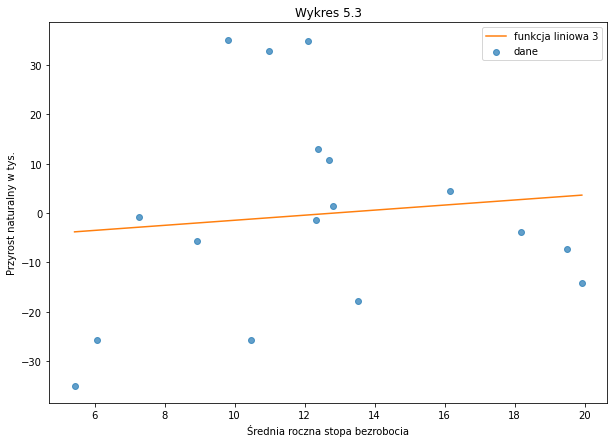

In [47]:
plt.figure(figsize=(10,7))
plt.scatter(X, Y, label='dane', alpha=0.7)
os_x = np.linspace(start=X.min(), stop=X.max(), num=300)
plt.plot(os_x, lin(x_opt_3, os_x), label='funkcja liniowa 3', color='tab:orange')
plt.ylabel("Przyrost naturalny w tys.")
plt.title("Wykres 5.3")
plt.xlabel("Średnia roczna stopa bezrobocia")
plt.legend()
plt.show()

Porównując wykresy 5.1 5.2 5.3 z modelem liniowym uzyskanym na wykresie 3.3 możemy zauważyć, że uzyskane modele w rozdziale "Zadanie 5d" są identyczne, a funkcje liniowe są rosnące, jednak prosta na wykresie 3.3 jest malejąca. Nie można zatem jednoznacznie określić czy zwiększanie bezrobocia jest działaniem poprawiającym sytuacje demograficzną polski.

# Krótkie podsumowanie

Sytuacja demograficzna w Polsce pogarsza się, co można zauważyć na wykresie 1.1. Należy za wszelką cenę podjąć kroki mające na celu poprawę tej sytuacji. Niestety, okazuje się, że nie ma jednoznacznej korelacji między stopą bezrobocia a przyrostem naturalnym. Należy wykreślić masowe zwolnienia z listy rozwiązań i spojrzeć na kolejne potencjalne pomysły. Ważne jest jednak to, żeby pamiętać, że dawanie ludziom pieniędzy proporcjonalnie do ilości potomstwa jest działaniem krótkowzrocznym z perspektywy gospodarczej i nie przyniesie długotrwałego wzrostu przyrostu naturalnego. Bedzie to jednak temat kolejnej pracy, jeśli kiedykolwiek powstanie.